In [1]:
from sklearn.datasets import make_regression, make_classification, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Neural Network classification

In [24]:
n = 10 # 10 features
X, y = make_classification(1000, n, n, 0, n_clusters_per_class=1, n_classes=2)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [30]:
net_structure = np.array([3, 3, 1]) # 3 neurons on 1st layer 3 on 2nd 1 on 3rd

# activation for each layer
activations = np.array(['sigmoid' for i in range(net_structure.shape[0])])

def relu(x: np.array, axis = 0):
  x[x <= 0] = 0
  return x

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def log_loss_cost(y, y_true):
  delta = 1e-8
  return np.mean(-(y_true * np.log(y + delta) + (1 - y) * np.log(1 - y_true + delta)))

def transform_dz(dz):
  # helper function
  new_dz = dict()
  new_dz['W'] = dict()
  new_dz['b'] = dict()

  for i in dz.keys():
    new_dz['W'][i] = dz[i]['W']
    new_dz['b'][i] = dz[i]['b']

  return new_dz

def init_weights(X, net_structure = np.array([3, 2, 1])):

  # W, b weights dict for W[1] weights of 1st layer
  W = dict()
  b = dict()

  l, r = -1, 1

  W[1] = np.random.uniform(l, r, (net_structure[0], X.shape[1]))
  b[1] = np.random.uniform(l, r, (net_structure[0], 1))

  for i in range(1, net_structure.shape[0]):
    W[i+1] = np.random.uniform(l, r, (net_structure[i], net_structure[i-1]))
    b[i+1] = np.random.uniform(l, r, (net_structure[i], 1))

  return {'W': W, 'b': b}

def forward_pass(X, net_structure, weights, activations):
  
  # A : activations for all layers A[l] - l'th layer
  A = dict()

  # first layer calculation
  if activations[0] == 'sigmoid':
      A[1] = sigmoid(X @ weights['W'][1].T + weights['b'][1].T)
  elif activations[0] == 'relu':
      A[1] = relu(X @ weights['W'][1].T + weights['b'][1].T)

  for i in range(2, net_structure.shape[0]+1):
    if activations[i-1] == 'sigmoid':
      A[i] = sigmoid(A[i-1] @ weights['W'][i].T + weights['b'][i].T)
    elif activations[i-1] == 'relu':
      A[i] = relu(A[i-1] @ weights['W'][i].T + weights['b'][i].T)
  
  return A

def backward_pass(X, y, net_structure, weights, A,  activations):
  W, b = weights['W'], weights['b']

  #derivatives of all layers dz[l] - l'th layer

  dz = dict()

  #last layer

  layer = net_structure.shape[0]

  if activations[0] == 'sigmoid':
    dz[layer] = dict()
    dz[layer]['W'] = np.zeros(W[layer].shape)
    dz[layer]['b'] = np.zeros(b[layer].shape)

    #print(W[layer].shape)

    for i in range(net_structure[layer-1]):
      W_transposed = W[layer][i].reshape(W[layer][i].shape[0], 1)
      derivative = sigmoid(A[layer-1] @ W_transposed + b[layer][i]) - y.reshape(y.shape[0], 1)
      dz[layer]['W'][i, :] = np.mean(derivative * A[layer-1], axis = 0, keepdims=True)
      dz[layer]['b'][i] = np.mean(derivative, axis = 0, keepdims=True)

  #hidden layers -  dz is multiplied with dz from l+1 layer
  for layer in range(net_structure.shape[0]-1, 1, -1):
    if activations[0] == 'sigmoid':
      dz[layer] = dict()
      dz[layer]['W'] = np.zeros(W[layer].shape)
      dz[layer]['b'] = np.zeros(b[layer].shape)

      #print(W[layer].shape)

      for i in range(net_structure[layer-1]):
        W_transposed = W[layer][i].reshape(W[layer][i].shape[0], 1)
        derivative = sigmoid(A[layer-1] @ W_transposed + b[layer][i]) - y.reshape(y.shape[0], 1)
        dz[layer]['W'][i, :] = np.mean(derivative * A[layer-1], axis = 0, keepdims=True)
        dz[layer]['b'][i] = np.mean(derivative, axis = 0, keepdims=True)

      dz[layer]['W'] = dz[layer]['W'] * np.mean(dz[layer+1]['W'].T, axis = 1).reshape(dz[layer]['W'].shape[0], 1)
      
      # MAY BE HERE
      #dz[layer]['b'] = dz[layer]['b'] * np.mean(dz[layer+1]['b'].T, axis = 1).reshape(dz[layer+1]['b'].shape[0], 1)
      dz[layer]['b'] = dz[layer]['b'] * np.mean(dz[layer+1]['b'].T, axis = 1)

    

  #first layer X instead of A[l-1]

  if activations[0] == 'sigmoid':
    dz[1] = dict()
    dz[1]['W'] = np.zeros(W[1].shape)
    dz[1]['b'] = np.zeros(b[1].shape)

    for i in range(net_structure[0]):
      W_transposed = W[1][i].reshape(W[1][i].shape[0], 1)
      derivative = sigmoid(X @ W_transposed + b[1][i]) - y.reshape(y.shape[0], 1)
      dz[1]['W'][i, :] = np.mean(derivative * X, axis = 0, keepdims=True)
      dz[1]['b'][i] = np.mean(derivative, axis = 0, keepdims=True)

    dz[1]['W'] = dz[1]['W'] * np.mean(dz[2]['W'].T, axis = 1).reshape(dz[1]['W'].shape[0], 1)
    dz[1]['b'] = dz[1]['b'] * np.mean(dz[2]['b'].T, axis = 1)
  

  return transform_dz(dz) #{'W': np.mean(dz * X, axis=0, keepdims=True), 'b': np.mean(dz)}

def update_weights(weights, dz, learning_rate = 0.01, logging = False):
  
  for j in ['W', 'b']:
    for i in weights[j].keys():
      weights[j][i] -= learning_rate * dz[j][i]
      if logging: print(j, i, 'weights:', weights[j][i].shape, 'dz', dz[j][i].shape)

  return weights

def fit(X, y, iterations = 200, learning_rate = 0.01, logging = False):
  
  global weights
  weights = init_weights(X, net_structure)

  for i in range(iterations):
    A = forward_pass(X, net_structure, weights, activations)
    dz = backward_pass(X, y, net_structure, weights, A, activations)
    weights = update_weights(weights, dz, learning_rate)
    if i % 100 == 0 and logging == True:
      print(log_loss_cost(A[net_structure.shape[0]], y))
  
    """print(weights)
    print(dz)
    print()"""

def predict_proba(X):
  return forward_pass(X, net_structure, weights, activations)[net_structure.shape[0]]

def predict(X, threshold = 0.5):
  return np.array([0 if i < threshold else 1 for i in predict_proba(X)])



fit(X_train, y_train, 500, 0.1, logging=True)
y_pred = predict(X_test)

print('test score', accuracy_score(y_test, y_pred))
print('train score', accuracy_score(predict(X_train), y_train))

1.354531677522379
4.878399564733733
4.912947751561955
4.913422889779443
4.913850776663406
test score 0.868
train score 0.808


# Linear equation

$ ax^2 + bx + c = d $

In [ ]:
a, b, c = [1, 2, 0]
d = 100

f = lambda x: a*x**2 + b*x + c

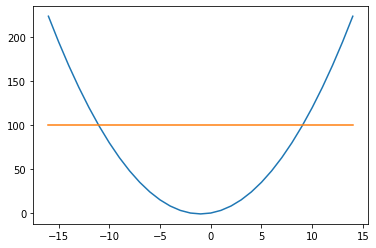

In [ ]:
l, r = -16, 15

x = np.arange(l, r)
y = f(x)

plt.plot(x, y)
plt.plot(x, [d for i in x])

In [ ]:
def loss(x):
  return abs(d - f(x))

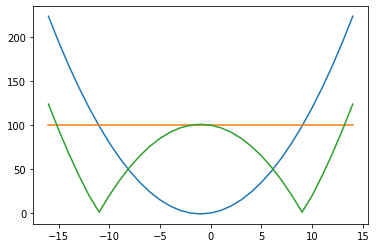

In [ ]:
x = np.arange(l, r)
y = f(x)

plt.plot(x, y)
plt.plot(x, [d for i in x])
plt.plot(x, loss(x))

In [ ]:
# for center

x_cur = r
x_path = []

deriv = lambda x: 2*a*x + b

alpha = 0.01

for i in range(300):
  x_cur -= alpha * deriv(x_cur)
  x_path.append(x_cur)

print(x_cur)
x_path = np.array(x_path)

-0.962679909312777


In [ ]:
# for solution

x_cur = x_cur
x_path_solution = []

deriv = lambda x: 2*a*x + b if f(x) > d else -2*a*x - b

alpha = 0.01

for i in range(300):
  x_cur -= alpha * deriv(x_cur)
  x_path_solution.append(x_cur)

print(x_cur)
x_path_solution = np.array(x_path_solution)

8.899821278636061


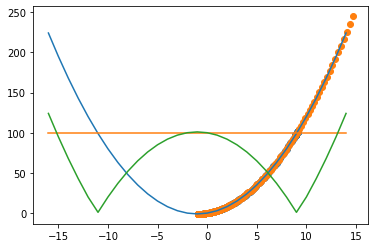

In [ ]:
plt.plot(x, y)
plt.plot(x, [d for i in x])
plt.plot(x, loss(x))
plt.scatter(x_path_solution, f(x_path_solution))
plt.scatter(x_path, f(x_path))

# Linear Regression

$ y = wx + b $

In [ ]:
X, y = make_regression(100, 1, 1, 1, 10, noise=10)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
X.shape

(100, 1)

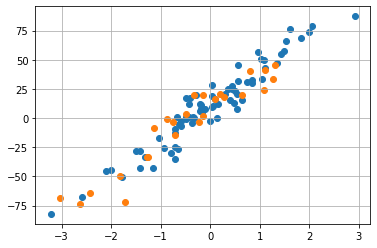

In [ ]:
plt.scatter(X_train[:, 0], y_train)
plt.scatter(X_test[:, 0], y_test)
plt.grid()

In [ ]:
def f(X, W, b):
  return X@W + b

def deriv(W, b, X, y):
  return {'W': np.mean(2 * (f(X, W, b) - y.reshape(y.shape[0], 1)) * X, axis = 0, keepdims=True).T, \
          'b': np.mean(2 * (f(X, W, b) - y.reshape(y.shape[0], 1)), axis = 0, keepdims=True)}

def MSE(X, y):
  return np.mean(np.power(f(X, W, b) - y, 2))

def fit(X, y):
  alpha = 0.01

  W = np.zeros(X.shape[1]).reshape(X.shape[1], 1)
  b = 0

  for i in np.arange(100):
    W -= deriv(W, b, X, y)['W'] * alpha
    b -= deriv(W, b, X, y)['b'] * alpha
  
  return W, b

def predict(X, y, W, b):
  return X@W + b

W, b = fit(X_train, y_train)

f = lambda x: W * x + b

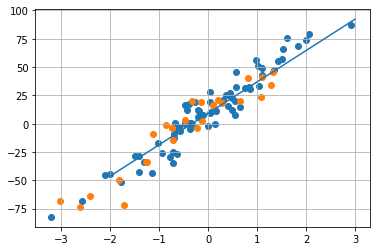

In [ ]:
plt.scatter(X_train[:, 0], y_train)
plt.scatter(X_test[:, 0], y_test)
plt.plot(np.linspace(-2, 3, 50), f(np.linspace(-2, 3, 50)).T)
plt.grid()

In [ ]:
X, y = make_moons(1000)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
X_train.shape

(750, 2)

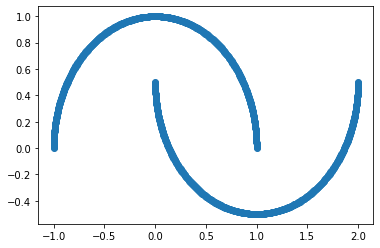

In [ ]:
plt.scatter(X[:,0], X[:,1])

# Logistic Regression

In [ ]:
X, y = make_moons(1000)
X_train, X_test, y_train, y_test = train_test_split(X, y)

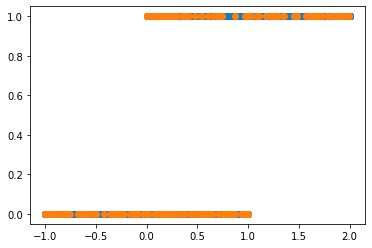

In [ ]:
plt.scatter(X_train[:, 0], y_train)
plt.scatter(X_test[:, 0], y_test)

In [ ]:
def init_weights(X, y):
  W = np.zeros((X_train.shape[1], 1))
  b = 0
  return {'W': W, 'b': b}

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def log_loss_cost(y, y_true):
  delta = 1e-5
  return np.mean(-(y_true * np.log(y + delta) + (1 - y) * np.log(1 - y_true + delta)))

def forward_pass(X, y, weights):
  W, b = weights['W'], weights['b']

  return sigmoid(X@W + b)

def backward_pass(X, y, weights):
  W, b = weights['W'], weights['b']

  dz = sigmoid(X@W + b) - y.reshape(y.shape[0], 1)
  return {'W': np.mean(dz * X, axis=0, keepdims=True), 'b': np.mean(dz)}

def fit(X, y, lr = 0.01, iterations = 100):

  global weights
  weights = init_weights(X, y)

  for i in range(iterations):
    weights['W'] -= lr * backward_pass(X, y, weights)['W'].T
    weights['b'] -= lr * backward_pass(X, y, weights)['b']
    #print(log_loss_cost(forward_pass(X, y, weights), y))

def predict_proba(X, y):
  return forward_pass(X, y, weights)

def predict(X, y, threshold = 0.5):
  return np.array([0 if i < threshold else 1 for i in forward_pass(X, y, weights)])

fit(X_train, y_train)
y_pred = predict(X_test, y_test)

In [ ]:
y_pred

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0])

In [ ]:
y_test

array([0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1.,
       1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0.])

In [ ]:
accuracy_score(y_test, y_pred)

0.7